The goal of this project is to use predictive analysis and machine learning models to determine which customers will transact and which customers won't based on the dataset provided by Kaggle.

##1. IMPORTING LIBRARIES



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn

#feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif,mutual_info_classif,SelectPercentile

#Preprocessing
from sklearn.preprocessing import MinMaxScaler

#metrics
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

#models
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

#model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import StratifiedKFold

#model validation
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from numpy import mean, std


from tqdm import tqdm
from imblearn.over_sampling import ADASYN


In [2]:
import sys

In [3]:
!python --version

Python 3.7.13


In [4]:
sklearn. __version__

'1.0.2'

In [5]:
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)

Due to the high data volume, the dataset is zipped and uploaded in Google Drive. The drive is mounted to Google Colab.

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


The Train and Test data are unzipped from the drive location.

In [7]:
!unzip /content/gdrive/MyDrive/train.zip
!unzip /content/gdrive/MyDrive/test.zip

Archive:  /content/gdrive/MyDrive/train.zip
  inflating: train.csv               
Archive:  /content/gdrive/MyDrive/test.zip
  inflating: test.csv                


In [ ]:
!pip3 install kaggle
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
user = "username"
key = "key"
if '.kaggle' not in os.listdir('/root'):
  !mkdir ~/.kaggle
  !touch /root/.kaggle/kaggle.json
  !chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
  f.write('{"username":"%s","key":"%s"}' % (user, key))
  !chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions submit competition-name -f submission.csv -m "submission message"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 562, in competition_submit_cli
    competition, quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 513, in competition_submit
    content_length=os.path.getsize(file_name),
  File "/usr/lib/python3.7/genericpath.py", line 50, in getsize
    return os.stat(filename).st_size
FileNotFoundError: [Errno 2] No such file or directory: 'submission.csv'


##2. DATA LOADING AND INSPECTING

In [ ]:
santanderDf = pd.read_csv('/content/train.csv',index_col=0)
santanderTestDf = pd.read_csv('/content/test.csv',index_col=0)

In [ ]:
santanderTestWithIndex=pd.read_csv('/content/test.csv')

Inspecting the training dataset:

1. There are 200 anonymous variables of the float64 datatype. This will consume huge memory space. So it needs to be reduced by converting it to float32 datatype. 

2. The target variable which is the class that needs to be predicted, is the only integer column.

In [ ]:
print(santanderDf.info())
print(santanderDf.head(3))

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, train_0 to train_199999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 308.2+ MB
None
         target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
ID_code                                                                      
train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   

           var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  \
ID_code                   ...                                                
train_0  18.6266 -4.9200  ...   4.4354   3.9642   3.1364   1.6910  18.5227   
train_1  16.5338  3.1468  ...   7.6421   7.7214   2.5837  10.9516  15.4305   
train_2  14.6155 -4.9193  ...   2.9057   9.7905   1.6704   1.6858  21.6042   

         var_195  var_196  var_19

In [ ]:
santanderDf.dtypes

target       int64
var_0      float64
var_1      float64
var_2      float64
var_3      float64
            ...   
var_195    float64
var_196    float64
var_197    float64
var_198    float64
var_199    float64
Length: 201, dtype: object

Memory usage is reduced by typecasting the datatypes.

In [ ]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Initial memory usage :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns with missing values
    for col in tqdm(df.columns):
        if df[col].dtype != object:  
            
            # Make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Capture NA as they will not be considered as Integer
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # Check if entire column can be converted to integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            
            # Integer/unsigned Integer datatypes conversion
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Float datatypes to float32 bit
            else:
                df[col] = df[col].astype(np.float32)
           
    # Final Result after memory reduction
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("The size has been reduced by ",100-(round(100*mem_usg/start_mem_usg,2)),"%")
    return df, NAlist

The size has been considerably reduced by almost 50%.

In [ ]:
santanderDf,NAlist=reduce_mem_usage(santanderDf)

Initial memory usage : 308.2275390625  MB


100%|██████████| 201/201 [00:08<00:00, 22.79it/s]

Memory usage is:  154.30450439453125  MB
The size has been reduced by  49.94 %


The data types are now changed for effective analysis process.

In [ ]:
santanderDf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, train_0 to train_199999
Columns: 201 entries, target to var_199
dtypes: float32(200), uint8(1)
memory usage: 154.3+ MB


##3. DATA VISUALIZATION

Let's start by attempting to determine the total number of classes and the percentage of each class in the dataset.

Check for Skewness and Kurtosis of the target variable.


In [ ]:
print('Skewness: %f' % santanderDf['target'].skew())
print('Kurtosis: %f' % santanderDf['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


There is a very high positive skew observed in the 'target' variable. This has high chances of affecting the analysis and prediction.

### Visualizing the skewed distribution of the 'target' variable in the training dataset.


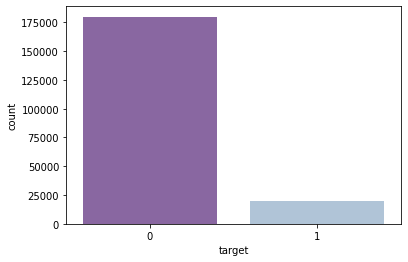

In [ ]:
# find the distribution of the target variable
sns.countplot(x=santanderDf['target'], palette='BuPu_r')

There is an imbalance between the classes  We have class 0  dominant cases (No transaction).

In [ ]:
print(santanderDf['target'].value_counts())

0    179902
1     20098
Name: target, dtype: int64


Looking close at the target Class 1, we can see that only 10 % of the data contains customers who made transaction.

In [ ]:
print("Target value 1: {}% ".format(santanderDf["target"].value_counts(normalize=True).mul(100).astype(str)[1]))

Target value 1: 10.049% 


Dealing with imbalance:

There are two approaches to imbalanced classification problems. 

1. Oversample the class lesser in proportion 
2. Undersample the dominant class

Since the proportion of class 0 is very high, lets over sample the class 1 using ADASYN. We avoid the use of Under sampling to prevent chances of losing important information pertaining to the higher volume data. 

ADASYN generates synthetic data without repeating minority class points. For each minority class point, it finds 'n' closest neighbors and constructs a line to all the neighbors. The points that lie on the line are randomly chosen with some variance to get the new point in the minority class.

##4. FEATURE ENGINEERING

    

Find the Correlation between variables to neglect redundancy.

In [ ]:
corr_metrics = santanderDf.corr()

In [ ]:
def get_redundant_pairs(santanderDf):
    
    pairs_to_drop = set()
    cols = santanderDf.columns
    for i in range(0, santanderDf.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [ ]:
def get_top_abs_correlations(santanderDf, n=5):
    
    au_corr = corr_metrics.abs().unstack()
    labels_to_drop = get_redundant_pairs(santanderDf)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

Variable var_81 seems to have the highest correlation value and considered the most crucial element for prediction.

In [ ]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(santanderDf, 20))

Top Absolute Correlations
target  var_81     0.080917
        var_139    0.074080
        var_12     0.069489
        var_6      0.066731
        var_110    0.064275
        var_146    0.063644
        var_53     0.063399
        var_26     0.062422
        var_76     0.061917
        var_174    0.061669
        var_22     0.060558
        var_21     0.058483
        var_99     0.058367
        var_166    0.057773
        var_80     0.057609
        var_190    0.055973
        var_2      0.055870
        var_165    0.055734
        var_13     0.055156
        var_148    0.055011
dtype: float64


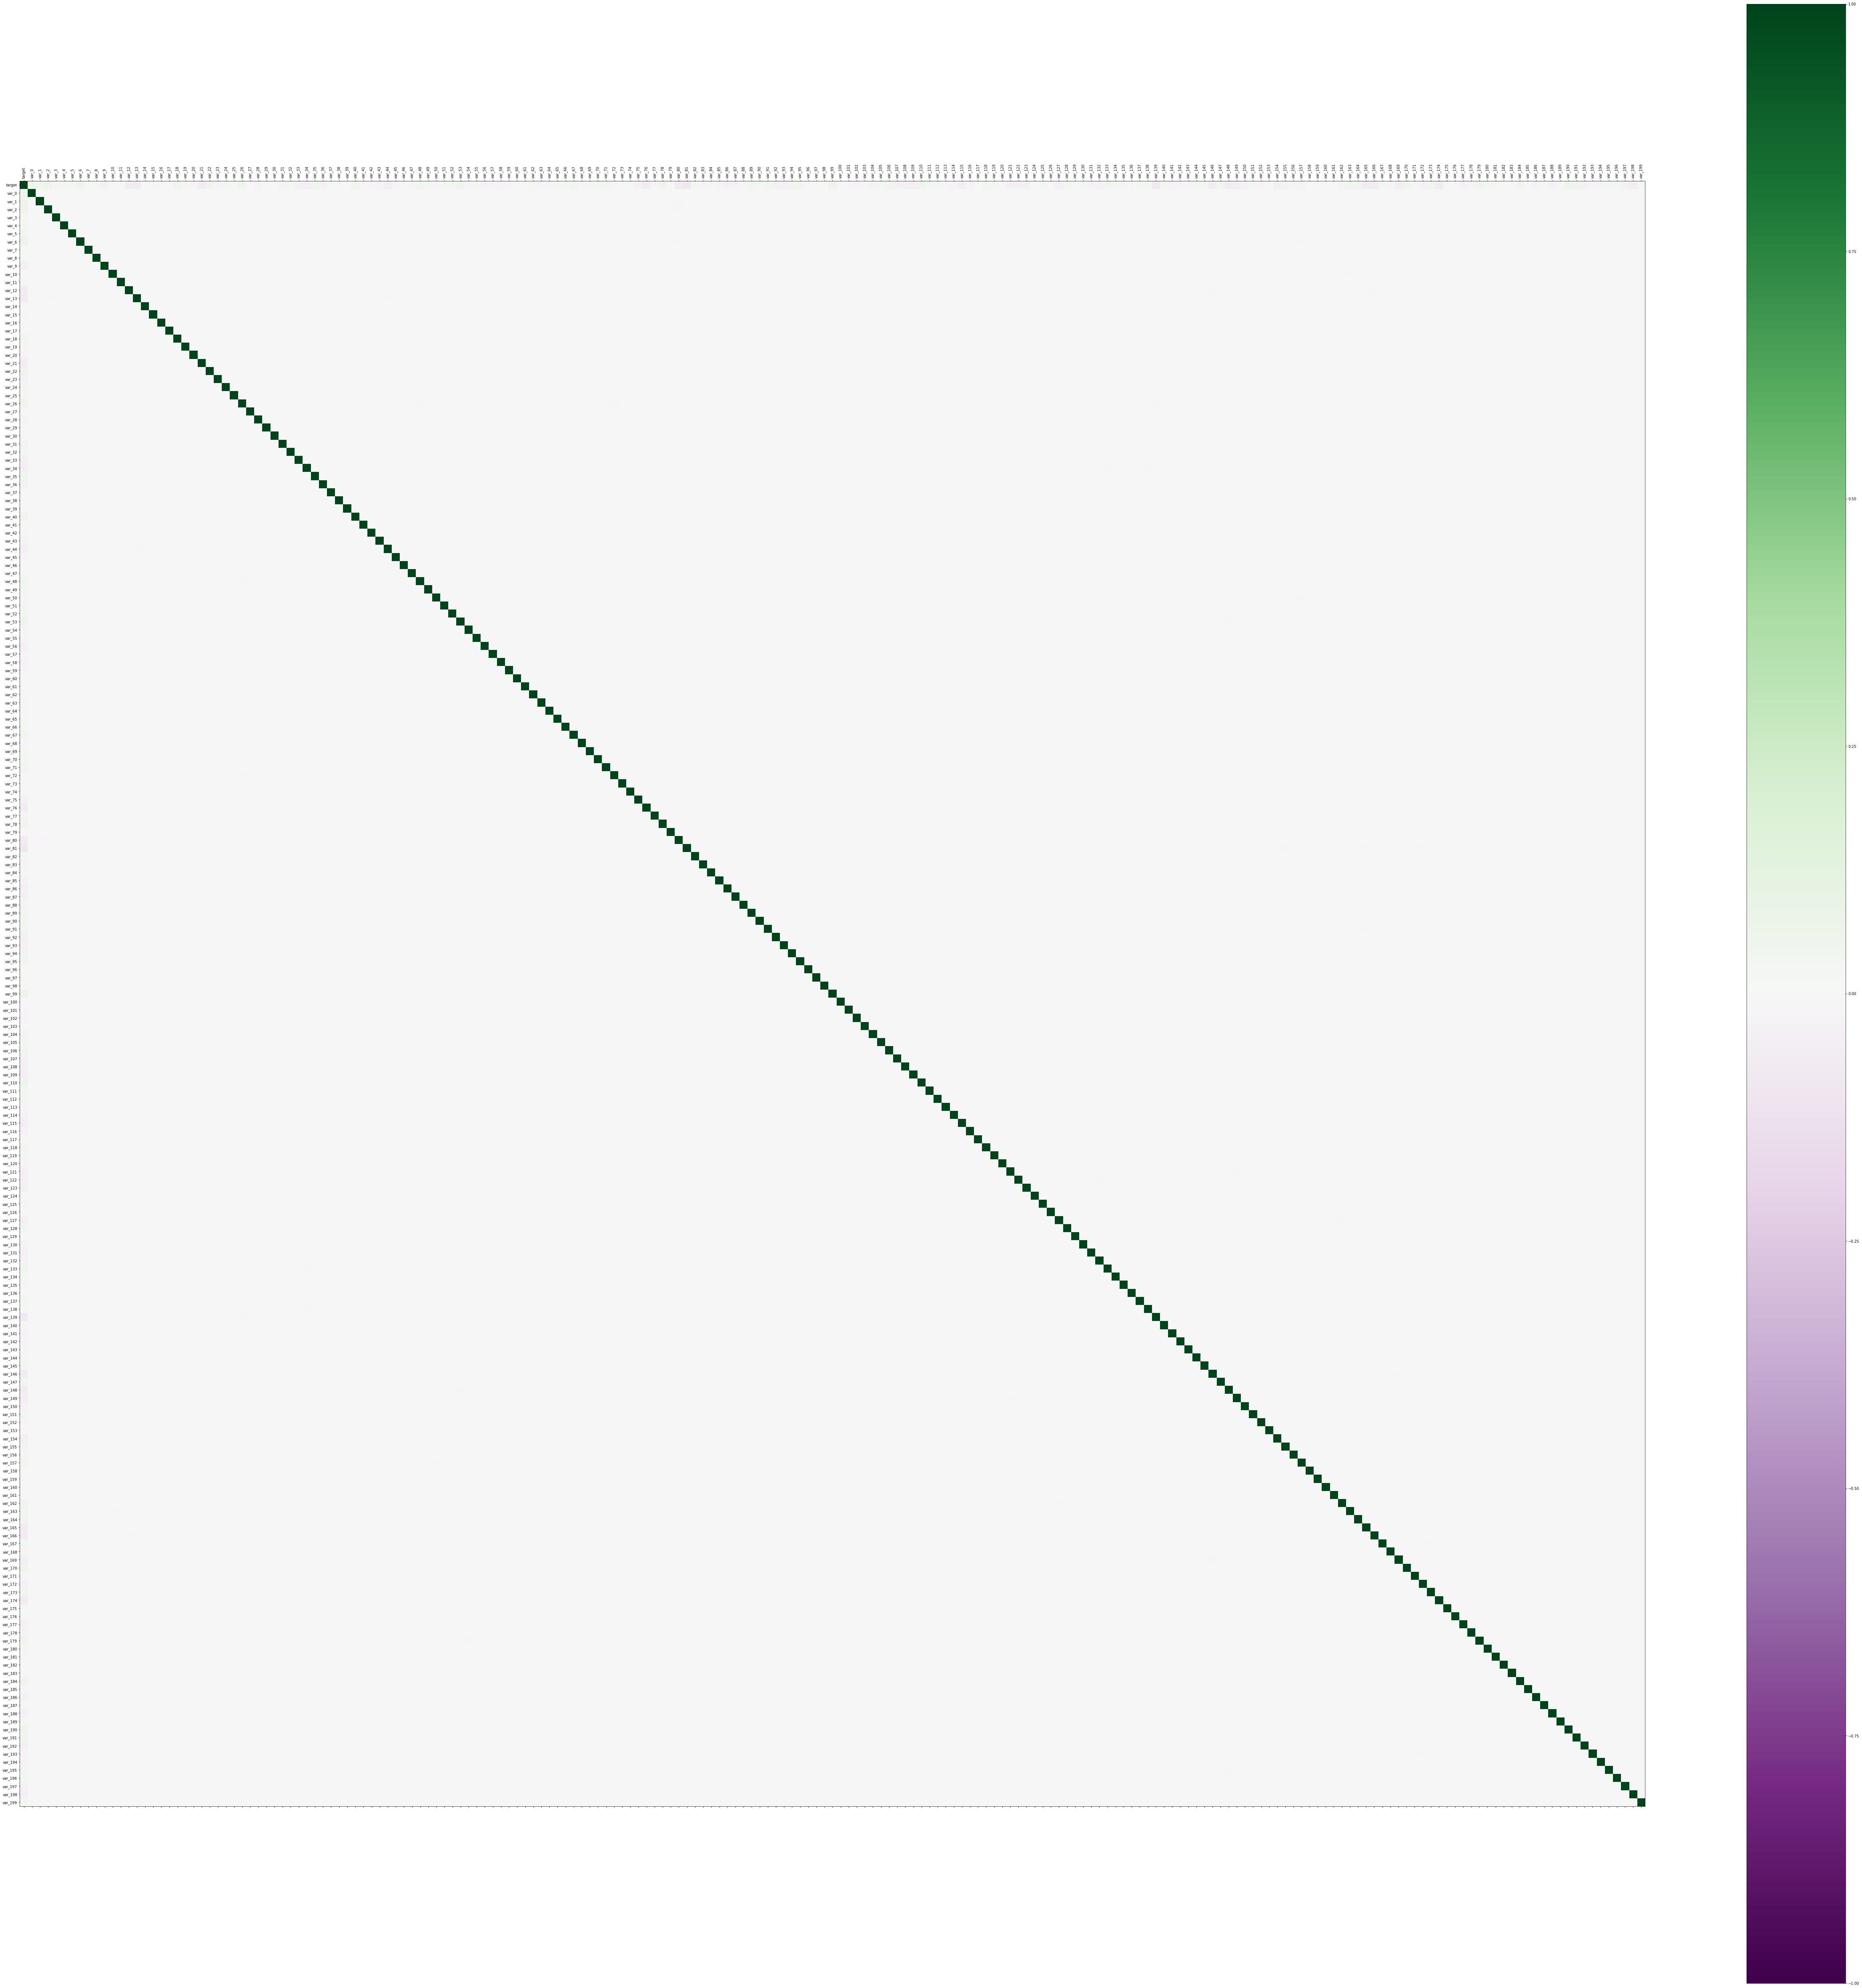

In [ ]:
fig = plt.figure(figsize=(100, 100))
ax = fig.add_subplot(111)
cax = ax.matshow(corr_metrics,cmap='PRGn', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(santanderDf.columns),1)

ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)

ax.set_xticklabels(santanderDf.columns)
ax.set_yticklabels(santanderDf.columns)

plt.show()

Though the top correlated features are shown, the values are very insignificant to neglect the features. We can conclude that there is no correlation between any feature in the training dataset.

In [ ]:
# convert the dataframe from wide to long
santanderDfMelt = santanderDf.melt(id_vars='target', var_name='Distribution')
santanderDfMelt.head()

,target,Distribution,value
0,0,var_0,8.9255
1,0,var_0,11.5006
2,0,var_0,8.6093
3,0,var_0,11.0604
4,0,var_0,9.8369


Distribution of the target variable among all 200 features  

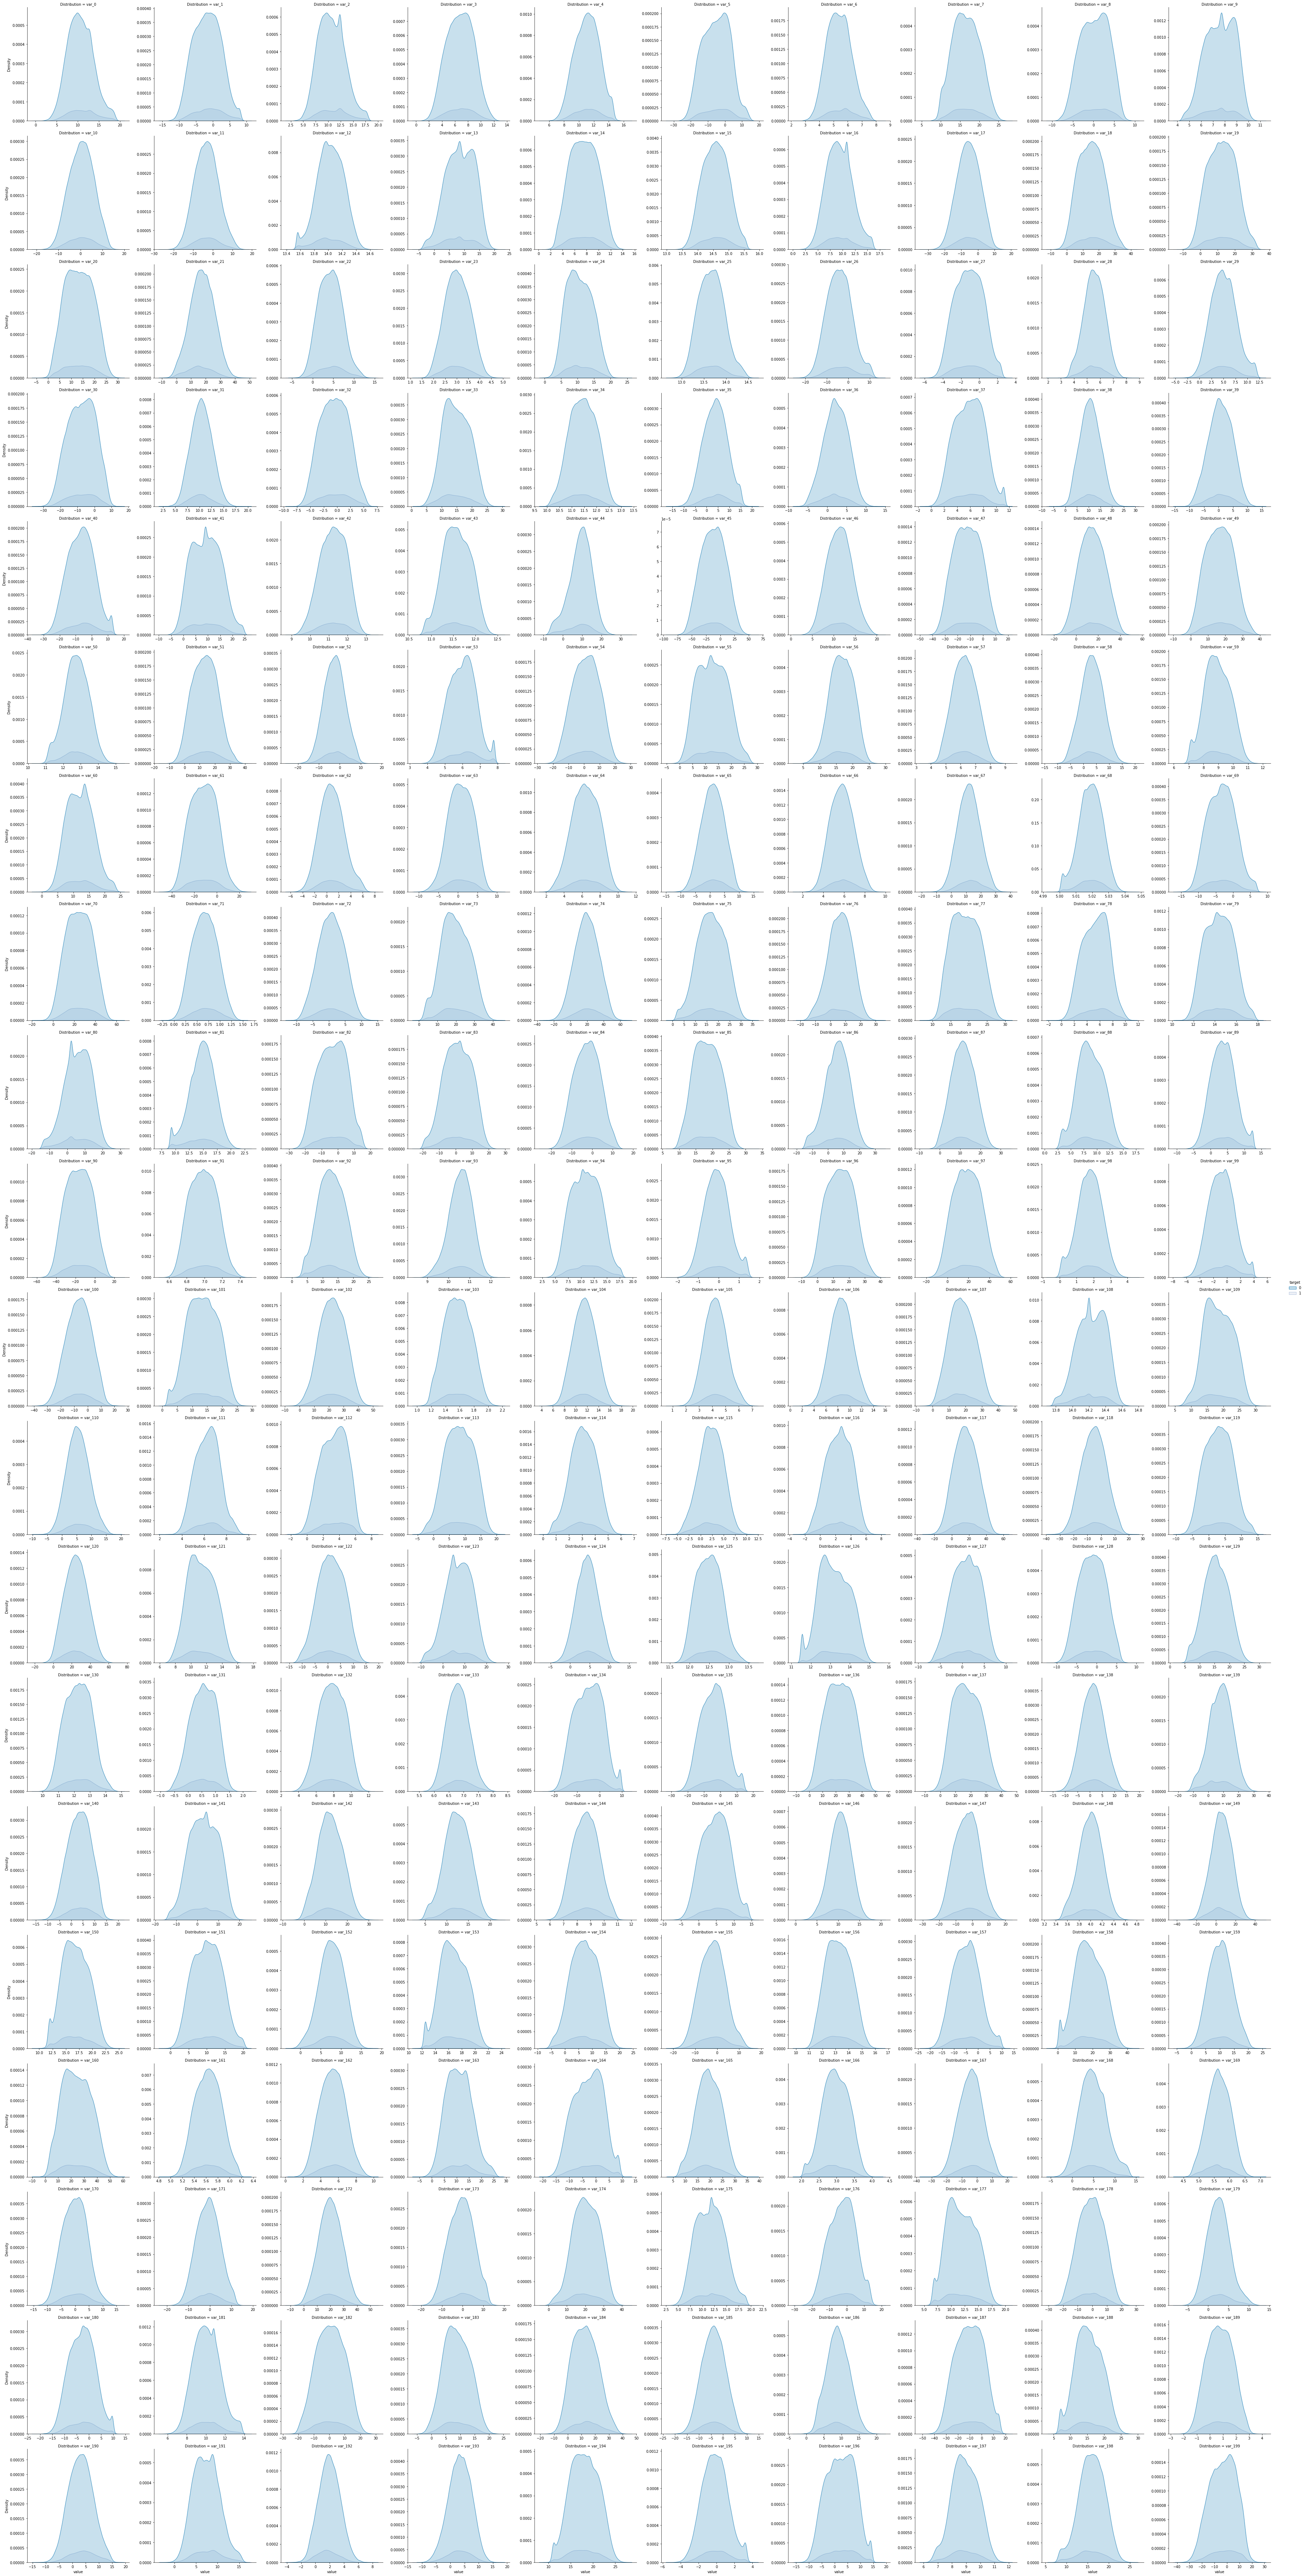

In [ ]:
sns.displot(kind='kde', data=santanderDfMelt, col='Distribution', col_wrap=10, x='value', hue='target', fill=True, facet_kws={'sharey': False, 'sharex': False}, palette='PuBu_r')

Check for missing values in both training and test data

In [ ]:
def check_missing_data(df):
    missingValues=santanderDf.isnull().sum().any()   

In [ ]:
print('Missing Values in Training Data:',check_missing_data(santanderDf))

Missing Values in Training Data: None


In [ ]:
print('Missing Values in Testing Data:',check_missing_data(santanderTestDf))

Missing Values in Testing Data: None


There are no missing values thus making the analysis less complicated.

##5. TEST MODEL PREPARATION

In [ ]:
X=santanderDf.drop('target',axis=1)
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.522699,-2.3978,7.8784,8.5635,12.780300,-1.0914
train_1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.430500,2.0339,8.1267,8.7889,18.356001,1.9518
train_2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.604200,3.1417,-6.5213,8.2675,14.722200,0.3965
train_3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.034700,-1.2706,-2.9275,10.2922,17.969700,-8.9996
train_4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.287600,-1.5121,3.9267,9.5031,17.997400,-8.8104


In [ ]:
y=santanderDf['target']
y.head()

ID_code
train_0    0
train_1    0
train_2    0
train_3    0
train_4    0
Name: target, dtype: uint8

ANOVA test can be applied for finding the crucial features using the f_classif function. It checks for Linear dependency. 

In [ ]:
F_stat,p_value = f_classif(X,y)
for col,stat,p in zip(X,F_stat,p_value):
    print(col,stat," : ",p)

var_0 550.2771735257529  :  1.6009348189141206e-121
var_1 508.17813631374946  :  2.183279254252716e-112
var_2 626.3436705913522  :  5.096249990156684e-138
var_3 24.282541277410406  :  8.325598534855992e-07
var_4 23.93773321476699  :  9.957942414756825e-07
var_5 192.13873569756126  :  1.1369495987988923e-43
var_6 894.378013493791  :  4.445354562871701e-196
var_7 1.5365914904671543  :  0.2151273233888957
var_8 76.74134386869748  :  1.9635758289294355e-18
var_9 367.00695840742617  :  9.93823384019115e-82
var_10 0.9798620493647705  :  0.32223406383743425
var_11 105.80455141501156  :  8.254656017135453e-25
var_12 880.1191341714674  :  5.419684402922683e-193
var_13 610.2432320391267  :  1.5785587224451228e-134
var_14 8.11049318779419  :  0.004401423637599789
var_15 44.825136098178966  :  2.160049101029823e-11
var_16 13.160488928061577  :  0.00028598536739064985
var_17 0.16252782754834097  :  0.6868402220045495
var_18 378.71453858517276  :  2.8379269610785944e-84
var_19 25.505546552365402  : 

In case of finding non-linear dependency, the mutual_info_classif function is used.

In [ ]:
# mutual_info_classif function
test_stat = mutual_info_classif(santanderDf.drop('target',axis=1),santanderDf.target)
for col,stat in zip(santanderDf.drop('target',axis=1),test_stat):
    print(col,stat)

var_0 0.0018677953004033743
var_1 0.0014480141883801423
var_2 0.0018919180294889593
var_3 0.0012505295025970753
var_4 0.0001303695916266001
var_5 0.0013037849565444848
var_6 0.0013698075506380913
var_7 0.0006685032395150614
var_8 0.0002799750574993265
var_9 0.0023975484418437
var_10 0.0009615000247176209
var_11 0.0
var_12 0.0033481866384139636
var_13 0.0022029074491025646
var_14 0.00010301825750946847
var_15 0.0017245080864920492
var_16 0.0004962218135131646
var_17 0.0
var_18 0.0005616069876328567
var_19 0.0006862115123869028
var_20 0.000362730661157995
var_21 0.002644478525417382
var_22 0.0021694000089718113
var_23 0.0002875682628398213
var_24 0.0007050399575816435
var_25 0.0
var_26 0.0027390506456177466
var_27 0.001107054761392945
var_28 0.0
var_29 0.0007021206521282686
var_30 0.0
var_31 0.0003209046081411593
var_32 0.0014667211197940677
var_33 0.0001777815523034132
var_34 0.0011446896080820057
var_35 0.0006217474671852408
var_36 0.00010193642403222292
var_37 0.0016386693370071814
va

We now use SelectPercentile class to select the best features falling within 35th percentile. 

In [ ]:
selector = SelectPercentile(percentile=35,score_func=mutual_info_classif)
X = pd.DataFrame(selector.fit_transform(X,y))
X.shape

(200000, 70)

There are 70 top performing features selected which is assumed to contribute the most to the target variable.

Below are the 70 features seleted for training the model.

In [ ]:
onlyFeaturesDf = santanderDf.drop("target", axis=1)
support = np.asarray(selector.get_support())
columns = np.asarray(onlyFeaturesDf.columns.values)
columns_with_support = columns[support]
print(columns_with_support)

['var_0' 'var_1' 'var_2' 'var_3' 'var_5' 'var_6' 'var_7' 'var_9' 'var_10'
 'var_12' 'var_13' 'var_15' 'var_21' 'var_22' 'var_26' 'var_29' 'var_32'
 'var_34' 'var_37' 'var_40' 'var_44' 'var_53' 'var_63' 'var_75' 'var_76'
 'var_78' 'var_80' 'var_81' 'var_83' 'var_87' 'var_91' 'var_92' 'var_93'
 'var_94' 'var_99' 'var_106' 'var_108' 'var_109' 'var_110' 'var_115'
 'var_118' 'var_119' 'var_121' 'var_123' 'var_127' 'var_131' 'var_132'
 'var_133' 'var_139' 'var_141' 'var_146' 'var_147' 'var_148' 'var_149'
 'var_154' 'var_164' 'var_165' 'var_166' 'var_169' 'var_170' 'var_172'
 'var_173' 'var_174' 'var_177' 'var_179' 'var_184' 'var_190' 'var_191'
 'var_198' 'var_199']


In [ ]:
X.columns = columns_with_support

In [ ]:
X.head()

,var_0,var_1,var_2,var_3,var_5,var_6,var_7,var_9,var_10,var_12,...,var_172,var_173,var_174,var_177,var_179,var_184,var_190,var_191,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,-9.2834,5.1187,18.6266,5.7470,2.9252,14.0137,...,20.877300,3.1531,18.561800,13.7241,1.7202,25.839800,4.4354,3.9642,12.780300,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,7.0433,5.6208,16.5338,8.0851,-0.4032,14.0239,...,22.033001,5.5134,30.264500,16.5721,11.0752,22.544100,7.6421,7.7214,18.356001,1.9518
2,8.6093,-2.7457,12.0805,7.8928,-9.0837,6.9427,14.6155,5.9525,-0.3249,14.1929,...,7.256900,-5.8234,25.681999,8.8438,2.4013,23.086599,2.9057,9.7905,14.722200,0.3965
3,11.0604,-2.1518,8.9522,7.1957,-1.8361,5.8428,14.9250,8.2450,2.3061,13.8463,...,18.236601,11.7134,14.748300,13.9552,5.6961,-0.463900,4.4666,4.7433,17.969700,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,2.4486,5.9405,19.2514,7.6784,-9.4458,13.8481,...,19.805599,2.3705,18.468500,13.5261,5.1743,11.850300,-1.4905,9.5214,17.997400,-8.8104


Scaling the Training Data

In [ ]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,stratify=y)

In [ ]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
133804,0.608868,0.426012,0.385161,0.570102,0.415365,0.482886,0.673451,0.738332,0.482773,0.619149,...,0.414859,0.648609,0.766384,0.237798,0.583127,0.692884,0.279908,0.517915,0.365600,0.728868
182550,0.674394,0.609468,0.229799,0.602336,0.558546,0.454741,0.454765,0.070264,0.572765,0.309287,...,0.650060,0.834636,0.681149,0.368688,0.731638,0.655498,0.657459,0.655991,0.337440,0.688123
160557,0.648820,0.699920,0.461885,0.405662,0.548767,0.339732,0.597137,0.336513,0.282210,0.148865,...,0.374255,0.625895,0.657370,0.468206,0.347842,0.725915,0.446296,0.731619,0.379438,0.344101
23886,0.393402,0.544040,0.471429,0.309468,0.622134,0.543669,0.745695,0.710129,0.302014,0.174030,...,0.448391,0.609788,0.391695,0.263021,0.358797,0.354118,0.480012,0.575819,0.619667,0.569532
65049,0.163473,0.737453,0.252804,0.606184,0.379380,0.580077,0.379007,0.155973,0.672028,0.586687,...,0.550001,0.589728,0.723764,0.285597,0.576626,0.450816,0.559045,0.382086,0.533201,0.432839


##6. MODEL BUILDING WITHOUT OVERSAMPLING

We are proceeding with Gradient Boosting Machine Model with data imbalance.

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,max_depth=9,verbose=1)
gbm.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           0.6411          117.49m
         2           0.6315          118.17m
         3           0.6225          117.73m
         4           0.6149          117.65m
         5           0.6074          117.24m
         6           0.6004          116.92m
         7           0.5938          117.79m
         8           0.5876          117.36m
         9           0.5815          116.88m
        10           0.5753          116.54m
        20           0.5265          114.28m
        30           0.4876          111.92m
        40           0.4547          109.92m
        50           0.4277          110.36m
        60           0.4025          110.32m
        70           0.3813          108.19m
        80           0.3621          105.00m
        90           0.3444          103.24m
       100           0.3289          101.43m
       200           0.2268           75.23m
       300           0.1765           51.86m
       40

In [ ]:
print(gbm.score(X_train,y_train))
print(gbm.score(X_test,y_test))

Classification Report: Precision, Recall, F1Score and Support

In [ ]:
y_pred = gbm.predict(X_test)
print(classification_report(y_pred,y_test))

NameError: ignored

The target 0 show a good precision and recall value whereas the class 1 has been poorly predicted by the classifier. The model has failed to capture the details of target 1, which is the aim of the project. 

##7. DATA PREPARATION USING OVERSAMPLING TECHNIQUE 

As discussed above, we are going to oversample the target 1 class in order to balance the data and then fit to the GBM model.

In [ ]:
df=santanderDf
X = df.iloc[:,1:]
y = df.target
sampler = ADASYN(random_state=0)
overSampler_X,overSampler_y = sampler.fit_resample(X,y)
overSampler_y.value_counts(dropna=False)

1    187938
0    179902
Name: target, dtype: int64

In [ ]:
df = pd.concat([overSampler_X,overSampler_y],axis=1)
df = df.sample(frac=1,random_state=1) 
df.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
254549,12.801032,-0.234137,7.204692,6.488525,11.877978,-10.991217,5.109015,14.690664,-1.997388,8.097424,...,9.527156,2.000823,7.005444,18.052214,0.437979,11.948676,9.252721,11.386613,7.455510,1
339646,11.758228,-4.113063,13.852328,10.214027,11.924109,6.935679,6.641500,19.971273,4.919980,7.165361,...,9.659922,2.442496,-0.161721,19.290916,0.161389,-2.082418,9.443250,15.682495,8.300173,1
288990,16.130705,-3.969707,10.118114,6.724830,11.085619,-8.204975,4.955093,11.683073,3.069200,7.396528,...,3.416596,2.465079,3.906832,21.049500,0.848300,5.334066,9.337712,14.847016,-12.612345,1
251370,7.643474,0.806717,12.113520,8.647463,13.101162,-14.492049,4.634995,16.021046,-2.708482,6.355035,...,6.108591,3.600922,5.629327,16.715065,-1.495991,9.069211,8.864333,10.627335,-8.150509,1
262933,8.988784,0.348474,9.613160,5.020276,9.147571,0.195828,5.549134,20.847315,1.022663,8.533281,...,6.400665,0.936761,7.735676,18.273100,0.595127,2.635184,8.829247,16.942816,6.520807,1


In [ ]:
# f_classif function
F_stat,p_value = f_classif(df.drop('target',axis=1),df.target)
for col,stat,p in zip(df.drop('target',axis=1),F_stat,p_value):
    print(col,stat," : ",p)

var_0 2881.189293421909  :  0.0
var_1 2767.273294411394  :  0.0
var_2 3501.9527750227126  :  0.0
var_3 178.1896842563034  :  1.2307515032587424e-40
var_4 140.03321211658087  :  2.6535052261712806e-32
var_5 950.9591013789709  :  1.518049920136466e-208
var_6 5418.751680858205  :  0.0
var_7 8.27461950846567  :  0.004020539659413569
var_8 367.49730557830696  :  7.197252909899713e-82
var_9 1934.4710025036175  :  0.0
var_10 0.48215859643780623  :  0.48744662317918397
var_11 590.582259258805  :  2.3738209191952006e-130
var_12 5397.1869609026335  :  0.0
var_13 3122.2327329491086  :  0.0
var_14 52.794100054423616  :  3.71140961725787e-13
var_15 296.4038138714791  :  2.1250413144966347e-66
var_16 17.05414027737696  :  3.633708828250406e-05
var_17 4.0996350663084264  :  0.042893191650004665
var_18 1957.0306760815697  :  0.0
var_19 72.000896807212  :  2.1587969649821885e-17
var_20 399.41724373061237  :  8.22401910290054e-89
var_21 3742.888074131841  :  0.0
var_22 3844.7633953663176  :  0.0
var_23 

In [ ]:
# mutual_info_classif function
test_stat = mutual_info_classif(df.drop('target',axis=1),df.target)
for col,stat in zip(df.drop('target',axis=1),test_stat):
    print(col,stat)

var_0 0.03959842431466032
var_1 0.029089558786277392
var_2 0.051689105601748775
var_3 0.0799039621812685
var_4 0.12308723323013449
var_5 0.012858582694037946
var_6 0.2648864181970978
var_7 0.024656678476774108
var_8 0.032341573201431606
var_9 0.18991751476384544
var_10 0.014128304721277019
var_11 0.013259834610757082
var_12 0.41623107742171905
var_13 0.022765515651621993
var_14 0.06237551133584551
var_15 0.36194241106067837
var_16 0.05086937828998517
var_17 0.01068514399741538
var_18 0.016171793985882754
var_19 0.0095654488803536
var_20 0.017625826886130014
var_21 0.01712232092516386
var_22 0.044825493550157525
var_23 0.3409141481740976
var_24 0.03075338035850006
var_25 0.3859919738423616
var_26 0.018519697381904177
var_27 0.13997464056230635
var_28 0.28456770060836223
var_29 0.04835199403540047
var_30 0.008732698956395613
var_31 0.07820321770848038
var_32 0.049782504036997244
var_33 0.025004625935480584
var_34 0.3340084732785318
var_35 0.017582744244097004
var_36 0.036753781343086045


Now we consider only the features in the top 35 percentile and drop the rest.

In [ ]:
X = df.drop('target',axis=1)
y = df.target
featureSelector = SelectPercentile(percentile=35,score_func=mutual_info_classif)
X = pd.DataFrame(featureSelector.fit_transform(X,y))
X.shape

(367840, 70)

Following are the columns with support

In [ ]:
onlyFeaturesDf = santanderDf.drop("target", axis=1)
support = np.asarray(featureSelector.get_support())
columns = np.asarray(onlyFeaturesDf.columns.values)
columns_with_support = columns[support]
print(columns_with_support)

['var_2' 'var_3' 'var_4' 'var_6' 'var_9' 'var_12' 'var_14' 'var_15'
 'var_16' 'var_23' 'var_25' 'var_27' 'var_28' 'var_31' 'var_32' 'var_34'
 'var_37' 'var_42' 'var_43' 'var_50' 'var_53' 'var_57' 'var_59' 'var_62'
 'var_64' 'var_66' 'var_68' 'var_71' 'var_78' 'var_79' 'var_81' 'var_88'
 'var_91' 'var_93' 'var_95' 'var_98' 'var_99' 'var_103' 'var_104'
 'var_105' 'var_106' 'var_108' 'var_111' 'var_112' 'var_114' 'var_115'
 'var_116' 'var_121' 'var_125' 'var_126' 'var_130' 'var_131' 'var_132'
 'var_133' 'var_144' 'var_146' 'var_148' 'var_150' 'var_153' 'var_156'
 'var_161' 'var_162' 'var_166' 'var_169' 'var_177' 'var_181' 'var_189'
 'var_192' 'var_195' 'var_197']


In [ ]:
X.columns = columns_with_support

Scaling the Data

In [ ]:
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X,y,random_state=1)

In [ ]:
X_test  = santanderTestDf

##8. MODELLING


In [ ]:
def confusionMatrixCalculation(y_val,y_pred):
  confusionMatrix = confusion_matrix(y_val, y_pred)
  print(confusionMatrix)
  return confusionMatrix

def classificationReport(y_val, y_pred):
  classReport = classification_report(y_val, y_pred)
  print(classReport)
  return classReport

###1. Light GBM Model

In [ ]:
params = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"auc",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 13,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}

In [ ]:
yPredLgb = np.zeros(len(X_test))
numOfRounds = 50000

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n)
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    print('Model Training')  
    lgb_model = lgb.train(params,train_data,numOfRounds,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 3500)
    print('model prediction started')      
    yPredLgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5
    print('model prediction over')

Fold 0
Model Training
Training until validation scores don't improve for 3500 rounds.
[1000]	training's auc: 0.886782	valid_1's auc: 0.886057
[2000]	training's auc: 0.894276	valid_1's auc: 0.89275
[3000]	training's auc: 0.899645	valid_1's auc: 0.897295
[4000]	training's auc: 0.903769	valid_1's auc: 0.900575
[5000]	training's auc: 0.907067	valid_1's auc: 0.902983
[6000]	training's auc: 0.909889	valid_1's auc: 0.904898
[7000]	training's auc: 0.912559	valid_1's auc: 0.906609
[8000]	training's auc: 0.914969	valid_1's auc: 0.908045
[9000]	training's auc: 0.917211	valid_1's auc: 0.909311
[10000]	training's auc: 0.919318	valid_1's auc: 0.910458
[11000]	training's auc: 0.921328	valid_1's auc: 0.91156
[12000]	training's auc: 0.923282	valid_1's auc: 0.912599
[13000]	training's auc: 0.925196	valid_1's auc: 0.913571
[14000]	training's auc: 0.92706	valid_1's auc: 0.914528
[15000]	training's auc: 0.928896	valid_1's auc: 0.915486
[16000]	training's auc: 0.930668	valid_1's auc: 0.916379
[17000]	traini

In [ ]:
y_pred = lgb_model.predict(X_val)

In [ ]:
def setThreshold(num):
  if num<0.5:
    return 0
  else:
    return 1

In [ ]:
threshold = np.vectorize(setThreshold)
y_pred_val = threshold(y_pred)

In [ ]:
conf_matrix = classification_report(y_pred_val,y_val)
print(conf_matrix)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     45421
           1       0.90      0.90      0.90     46539

    accuracy                           0.90     91960
   macro avg       0.90      0.90      0.90     91960
weighted avg       0.90      0.90      0.90     91960



In [ ]:
# for submission
submission_lgb = pd.DataFrame({
        "ID_code": santanderTestWithIndex["ID_code"],
        "target": yPredLgb
    })
submission_lgb.to_csv('submission_lgb.csv', index=False)

In [ ]:
submissionFileDf = pd.read_csv('/content/submission_lgb.csv')
submissionFileDf.head()

,ID_code,target
0,test_0,1.0
1,test_1,1.0
2,test_2,1.0
3,test_3,1.0
4,test_4,1.0


In [ ]:
example = lgb_model.predict(X_val)

In [ ]:
example.shape

(91960,)

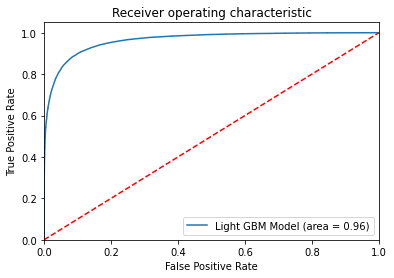

In [ ]:
lgbm_roc_auc = roc_auc_score(y_val, lgb_model.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, example)
plt.figure()
plt.plot(fpr, tpr, label='Light GBM Model (area = %0.2f)' % lgbm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LightGBM_ROC')
plt.show()

In [ ]:
confMatrix = confusionMatrixCalculation(y_pred_val,y_val)

[[40613  4808]
 [ 4455 42084]]


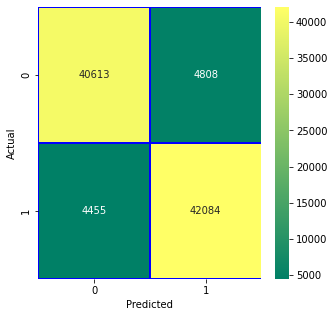

In [ ]:
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(confMatrix,annot=True,linewidths=0.5,linecolor="blue",fmt=".0f",ax=ax,cmap='summer')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
param_grid = {'learning_rate': (-1.0, 1.0),
'num_leaves': (5,15),
'feature_fraction': (0, 0.05),
'bagging_fraction': (0,0.5),
'max_depth': (5, 30),
'max_bin':(20,90),
'min_data_in_leaf': (50,80),
'min_sum_hessian_in_leaf':(0,20),
'subsample': (0.01, 1.0)}
 
# Instantiate light gbm classifier
lgbm = lgb.LGBMClassifier()
 
# Instantiate the GridSearchCV object: logreg_cv
lgbm_cv = GridSearchCV(lgbm, param_grid, cv=5)
 
# Fit it to the data
lgbm_cv.fit(X_train, y_train)
 
# Print the tuned parameter and score
print("Tuned light GBM Parameters are: {}".format(lgbm_cv.best_params_))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2240 fits failed out of a total of 2560.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1280 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py", line 197, in train
    booster = Booster(params=params, train_set=train_set)
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1552, in __init__
    train_set.construct().handle,
  File "/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py", line 1001, in construct
    categorical_feature=self.categorical_feature, params=self.params)
  File "/usr/local/lib/python3.7/dist-packages/l

Tuned light GBM Parameters are: {'bagging_fraction': 0.5, 'feature_fraction': 0.05, 'learning_rate': 1.0, 'max_bin': 90, 'max_depth': 5, 'min_data_in_leaf': 50, 'min_sum_hessian_in_leaf': 20, 'num_leaves': 15, 'subsample': 0.01}


In [ ]:
print("Best score is {}".format(lgbm.best_score_))

NotFittedError: ignored

###2. GBM Model

In [ ]:
gbm = GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,max_depth=9,verbose=1)
gbm.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           1.3702          253.56m
         2           1.3556          254.99m
         3           1.3414          252.45m
         4           1.3276          250.68m
         5           1.3145          250.04m
         6           1.3016          249.25m
         7           1.2894          249.74m
         8           1.2774          248.90m
         9           1.2658          248.41m
        10           1.2544          247.67m
        20           1.1551          242.93m
        30           1.0747          237.48m
        40           1.0077          232.80m
        50           0.9499          227.44m
        60           0.8997          222.12m
        70           0.8554          217.24m
        80           0.8159          212.54m
        90           0.7804          207.72m
       100           0.7482          202.81m


In [ ]:
print(gbm.score(X_train,y_train))
print(gbm.score(X_val,y_val))

In [ ]:
y_pred = gbm.predict(X_val)
print(classification_report(y_pred,y_val))

In [ ]:
noskill_pred = [0 for i in range(len(X_val))]
mod_pred = gbm.predict_proba(X_val)
mod_pred_posv = mod_pred[:,1]

In [ ]:
ns_fpr, ns_tpr, _ = roc_curve(y_val, noskill_pred)
mod_fpr, mod_tpr, _ = roc_curve(y_val, mod_pred_posv)

There is a very smooth trade off between the FPR and TPR for the GBM model.

In [ ]:
gbm_roc_auc = roc_auc_score(y_val, gbm.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, gbm.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='GBM Model (area = %0.2f)' % gbm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Gbm_ROC')
plt.show()

TypeError: ignored

In [ ]:
print(auc(mod_fpr, mod_tpr))

0.9644433151527757


Text(0, 0.5, 'actual')

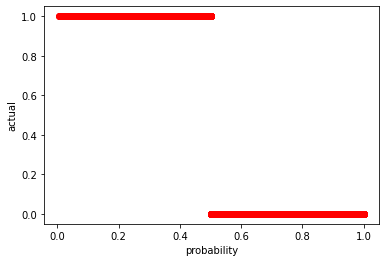

In [ ]:
plt.scatter(mod_pred[:,0],y_pred,color='red')
plt.xlabel('probability')
plt.ylabel('actual')

In [ ]:
#append predicted value and actual test case value to a new DataFrame
actualVsPredTest=pd.DataFrame()
actualVsPredTest['actual']=y_val
actualVsPredTest['predicted']=y_pred
actualVsPredTest['Pos Value']=mod_pred_posv

In [ ]:
actualVsPredTest.head()

,actual,predicted,Pos Value
157921,0,0,0.043360
213265,1,1,0.962635
83377,0,0,0.112503
143991,0,1,0.740522
139984,0,0,0.277362


In [ ]:
confusionMatrixCalculation(y_val,y_pred)

[[40208  4860]
 [ 4022 42870]]


array([[40208,  4860],
       [ 4022, 42870]])

In [ ]:
confMatrix = confusionMatrixCalculation(y_val,y_pred)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(confMatrix,annot=True,linewidths=0.5,linecolor="blue",fmt=".0f",ax=ax,cmap='summer')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

###3.Logistic Regression Model

In [ ]:
logReg = LogisticRegression()
logReg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = logReg.predict(X_val)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(logReg.score(X_val, y_val)))

Accuracy of logistic regression classifier on validation set: 0.70


In [ ]:
confMatrix = confusionMatrixCalculation(y_val,y_pred)


[[30444 14624]
 [12864 34028]]


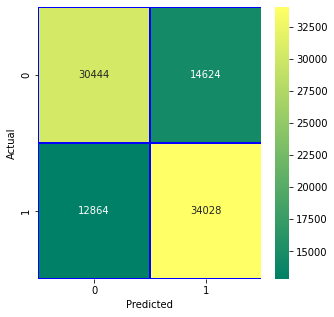

In [ ]:
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(confMatrix,annot=True,linewidths=0.5,linecolor="blue",fmt=".0f",ax=ax,cmap='summer')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
classificationReport(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.70      0.68      0.69     45068
           1       0.70      0.73      0.71     46892

    accuracy                           0.70     91960
   macro avg       0.70      0.70      0.70     91960
weighted avg       0.70      0.70      0.70     91960



'              precision    recall  f1-score   support\n\n           0       0.70      0.68      0.69     45068\n           1       0.70      0.73      0.71     46892\n\n    accuracy                           0.70     91960\n   macro avg       0.70      0.70      0.70     91960\nweighted avg       0.70      0.70      0.70     91960\n'

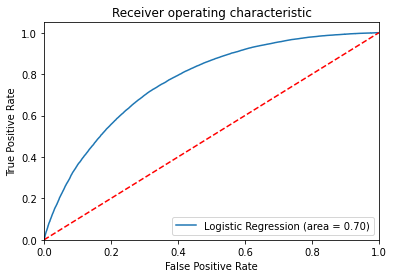

In [ ]:
logit_roc_auc = roc_auc_score(y_val, logReg.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, logReg.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

###4. Random Forest Classifier Model

We are going to train the dataset with RandomForest classifier to compare results.

In [ ]:
randomForestModel=RandomForestClassifier(n_estimators=500,max_depth= 17,verbose=2)
randomForestModel.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 37.4min finished


RandomForestClassifier(max_depth=17, n_estimators=500, verbose=2)

In [ ]:
randomForestModel.score(X_train,y_train)
randomForestModel.score(X_val,y_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   45.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.1s finished


0.8762287951283166

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.5s finished


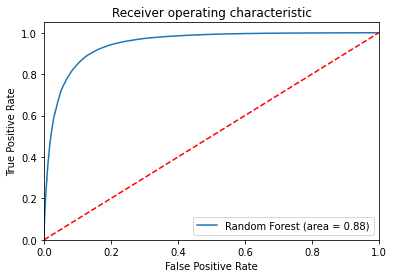

In [ ]:
random_roc_auc = roc_auc_score(y_val, randomForestModel.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, randomForestModel.predict_proba(X_val)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % random_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Random_ROC')
plt.show()

In [ ]:
y_pred=randomForestModel.predict(X_val)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   14.9s finished


Confusion Matrix for the Random Forest Classifier Model

In [ ]:
confMatrix = confusionMatrixCalculation(y_val,y_pred)

[[36874  8194]
 [ 3188 43704]]


In [ ]:
print(confMatrix)

[[36874  8194]
 [ 3188 43704]]


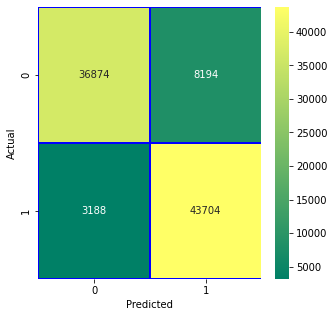

In [ ]:
f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(confMatrix,annot=True,linewidths=0.5,linecolor="blue",fmt=".0f",ax=ax,cmap='summer')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
classReport = classificationReport(y_val,y_pred)

              precision    recall  f1-score   support

           0       0.92      0.82      0.87     45068
           1       0.84      0.93      0.88     46892

    accuracy                           0.88     91960
   macro avg       0.88      0.88      0.88     91960
weighted avg       0.88      0.88      0.88     91960



##9. VALIDATION
We use Shuffle split cross validation technique to validate our models.

In [ ]:
cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)

In [ ]:
logisticRegressionModel= cross_val_score(LogisticRegression(), X_val, y_val, cv=cv)
print('Accuracy: %.3f (%.3f)' % (mean(logisticRegressionModel), std(logisticRegressionModel)))

Accuracy: 0.697 (0.004)


In [ ]:
randomForestModel = cross_val_score(RandomForestClassifier(), X_val, y_val, cv=cv)
print('Accuracy: %.3f (%.3f)' % (mean(randomForestModel),std(randomForestModel)))


Accuracy: 0.865 (0.002)


In [ ]:
gbmModel= cross_val_score(GradientBoostingClassifier(), X_val, y_val, cv=cv)
print('Accuracy: %.3f (%.3f)' % (mean(gbmModel), std(gbmModel)))

Accuracy: 0.780 (0.002)


The light GBM model already comes with inbuild cross validation function and therefore it is not necessary to repeat it.

We can see from cross validation results that the light GBM model performs better than all other models and that logistic regression is the poorly performing model.

##10. Conclusion:
The light GBM model is therefore chosen for testing as it has provided the best validation results. The model results were uploaded in the Kaggle platform and finally is concluded that the light GBM is the top performing model compared to the other 3 classification models used.